In [1]:
projectdir = "C:/Users/arman/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, Pipe, ProgressMeter, StatsPlots, Distributed, Roots, LinearAlgebra, BSON, Random
pyplot()

try 
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try SeqDataFormatting
catch e
    include(projectdir*"experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include(projectdir*"distribution_functions.jl")
include(projectdir*"simulated_tumors/path_format.jl")
include(projectdir*"Turnover/src/utility.jl")
include(projectdir*"sampling_analysis/plot_funcs.jl")
include("sampling_analysis/lichee_cloneclustering.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\arman\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


LoadError: ArgumentError: Package DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.


In [2]:
rmprocs(workers())
addprocs(4)
@everywhere using Pkg
@everywhere Pkg.activate(pwd())
@everywhere import TumorGrowth

LoadError: UndefVarError: workers not defined

# Data

In [3]:
tumorinfo_2d = filter( r-> r.d == 0.975, dir_info_mutations(projectdir*"/simulated_tumors/2d_poisson/bulk") )
# tumorinfo_2d_series = filter( r-> r.d != 0.98 && r.N == 10000, dir_info_mutations(projectdir*"/simulated_tumors/2d/bulk") )
tumorinfo_3d = filter( r-> r.d == 0.975, dir_info_mutations(projectdir*"/simulated_tumors/3d_poisson/bulk") )
# tumorinfo_nonspatial = dir_info_mutations(projectdir*"/simulated_tumors/nonspatial");

In [4]:
nrow(tumorinfo_3d)

40

In [5]:
tumorinfo = tumorinfo_3d

tumorinfo.tumor = @showprogress pmap(TumorGrowth.data_import, tumorinfo.tumorpath)
tumorinfo.mutations = @showprogress pmap(TumorGrowth.data_import, tumorinfo.mutationspath)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:02:56
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


# Example

In [265]:
Random.seed!(2022)
tumor = deepcopy( tumorinfo_nonspatial.tumor[1] )

tumor = tumor[sample(1:nrow(tumor), 285, replace=false), :]
tumor.index .= 1:nrow(tumor)

nmuts = length(union(tumor.mutations...))
TumorGrowth.reduced_μ!(tumor, 50 / nmuts)
tumor.frequencies = map(ones, length.(tumor.mutations))
tumor.sample_r = ones(nrow(tumor));

In [304]:
params = read_params(tumorinfo_nonspatial.tumorpath[1])
name = write_path(;params...)[1]

"tumor_N40000_b1.0_d0.98_μ0.015_ρInf_0d_id1009.csv"

> coinc

In [286]:
# clones, sample_clone_mix = coincidence_clustering(tumor)
clonetumor_coinc = coincidence_clustering_clonetumor(tumor)
first(clonetumor_coinc,4)

,new_index,mutations
,Int64,Array…
1,1,[10]
2,2,[10]
3,3,[10]
4,4,[10]


In [290]:
clonetumor_coinc.mutations |> unique .|> length |> countmap

Dict{Int64, Int64} with 4 entries:
  4 => 4
  2 => 30
  3 => 9
  1 => 2

In [309]:
CSV.write("simulated_tumors/lichee/clonetumor_coinc_$(name)", delim="\t",  clonetumor_coinc)

"simulated_tumors/lichee/clonetumor_coinc_tumor_N40000_b1.0_d0.98_μ0.015_ρInf_0d_id1009.csv"

> LICHeE

In [312]:
mut2ind, snv_lichee = get_lichee_format(tumor);

In [313]:
CSV.write("simulated_tumors/lichee/tumorsim_lichee.csv", delim="\t",  snv_lichee);

In [314]:
lichee_dir = joinpath("C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/",
    "Workspace/lichee/LICHeE/release")
input = joinpath(projectdir, "simulated_tumors/lichee/tumorsim_lichee.csv")
lichee_cmd = `bash ./lichee -build -i $input -maxVAFAbsent 0.005 -minVAFPresent 0.01 -n 0 -maxClusterDist 0 -minClusterSize 1 -minProfileSupport 1 minRobustNodeSupport 1 -s 1 -sampleProfile`
run(Cmd(lichee_cmd, dir=lichee_dir));

There are 46 SNVs in the input file. 
After pre-processing, the input consists of 46 somatic SNVs. 

Found 1 valid tree(s)


In [315]:
data, offspring2parent = load_lichee_output("simulated_tumors/lichee/tumorsim_lichee.csv.trees.txt", mut2ind = mut2ind);

In [316]:
clonetumor_lichee = lichee_clonetumor(tumor, data)
first(clonetumor_lichee,4)

,index,sample_index,position,mutations,sample_frequency,sample_r
,Int64,Int64,Array…,Array…,Float64,Float64
1,1,277,[],"[13289, 10]",0.5,1.0
2,2,31,[],"[13024, 10]",0.5,1.0
3,3,138,[],"[10749, 10]",0.5,1.0
4,4,198,[],"[6848, 245, 10]",0.5,1.0


In [317]:
clonetumor_lichee.mutations |> unique .|> length |> countmap

Dict{Int64, Int64} with 4 entries:
  4 => 4
  2 => 30
  3 => 9
  1 => 2

In [318]:
CSV.write("simulated_tumors/lichee/clonetumor_lichee_$(name)", delim="\t",  clonetumor_lichee)

"simulated_tumors/lichee/clonetumor_lichee_tumor_N40000_b1.0_d0.98_μ0.015_ρInf_0d_id1009.csv"

#  Method

In [6]:
clustering_method = samplingtumor -> begin
    
    tempfile = joinpath(projectdir, "simulated_tumors/lichee/tumorsim_lichee_temp.csv")
    lichee_dir = joinpath(projectdir, "../../lichee/LICHeE/release")
    
    clonetumor_coinc = coincidence_clustering_clonetumor(samplingtumor)
    
    mut2ind, snv_lichee = get_lichee_format(samplingtumor)
    select!(snv_lichee, Not(:profile))
    CSV.write(tempfile, delim="\t",  snv_lichee)
    clonetumor_lichee = DataFrame(:index => [0], :mutations=>[[]])
    
    try
        lichee_cmd = `bash ./lichee -build -i $tempfile -maxVAFAbsent 0.005 -minVAFPresent 0.01 -n 0 -maxClusterDist 0 -minClusterSize 1 -minProfileSupport 1 minRobustNodeSupport 1 -s 1`# -sampleProfile`
        run(Cmd(lichee_cmd, dir=lichee_dir))
        data, offspring2parent = load_lichee_output(tempfile*".trees.txt", mut2ind = mut2ind)
        clonetumor_lichee = lichee_clonetumor(samplingtumor, data)
    catch e
    end
    
    sort!(clonetumor_lichee.mutations)
    (clonetumor_coinc = clonetumor_coinc, clonetumor_lichee = select(clonetumor_lichee, :index, :mutations), )
end

#194 (generic function with 1 method)

In [22]:
samplecutoff= 1/3
samplingparams = (n = 285, cells_per_sample = 10)

sampling_method = tumor -> begin
    _, wes_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = 30, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 20)

    mutations_wes = TumorGrowth.sampletumor_mfreqs(wes_sample)
    filter!(m->m.frequency>1/40, mutations_wes)
    # mutations_wes = mutations_wes[sample(1:nrow(mutations_wes), 35),:]

    _, sanger_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 10)

    for row in eachrow(sanger_sample)
        mask = [ m in mutations_wes.mutation && f > samplecutoff for (m,f) in zip(row.mutations, row.frequencies) ]
        row.mutations = row.mutations[mask]
        row.frequencies = row.frequencies[mask]
    end
    sanger_sample
end

#232 (generic function with 1 method)

In [7]:
samplecutoff= 1/3
samplingparams = (n = 275, cells_per_sample = 5)

sampling_method = tumor_3d -> begin
    
    x, cm = mean(tumor_3d.position)
    tumor = TumorGrowth.cross_section(tumor_3d; x=x, width=2.5, reduce_dim=true)
    
    _, wes_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = 30, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 20)

    mutations_wes = TumorGrowth.sampletumor_mfreqs(wes_sample)
    filter!(m->m.frequency>1/40, mutations_wes)
    # mutations_wes = mutations_wes[sample(1:nrow(mutations_wes), 35),:]

    _, sanger_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 10)

    for row in eachrow(sanger_sample)
        mask = [ m in mutations_wes.mutation && f > samplecutoff for (m,f) in zip(row.mutations, row.frequencies) ]
        row.mutations = row.mutations[mask]
        row.frequencies = row.frequencies[mask]
    end
    sanger_sample
end

#196 (generic function with 1 method)

In [28]:
sampling_method = tumor -> begin
    
    # mutations = TumorGrowth.mutation_freqs(tumor[sample(1:nrow(tumor), 100, replace=false),:] )
    # filter!(r->r.reads > 4, mutations)
    
    samplingtumor = deepcopy( tumor[sample(1:nrow(tumor), 2000, replace=false), :] )
    
    mutations = TumorGrowth.mutation_freqs(samplingtumor)
    filter!(r->r.reads > 10, mutations)
    
    filter!.(m -> m in mutations.mutation, samplingtumor.mutations)
    samplingtumor.index .= 1:nrow(samplingtumor)
    samplingtumor.frequencies = map(ones, length.(samplingtumor.mutations))
    samplingtumor.sample_r = ones(nrow(samplingtumor));
    samplingtumor
end

#214 (generic function with 1 method)

In [10]:
tumorinfo_nonspatial.tumor[1] |> sampling_method  |> clustering_method

There are 273 SNVs in the input file. 
After pre-processing, the input consists of 273 somatic SNVs. 

Found 1 valid tree(s)


(clonetumor_coinc = 2000×2 DataFrame
  Row │ new_index  mutations                         
      │ Int64      Array…                            
──────┼──────────────────────────────────────────────
    1 │         1  [8, 20, 24, 31, 47, 195, 281]
    2 │         2  [8, 35, 51, 177]
    3 │         3  [8, 20, 24, 31, 47, 218]
    4 │         4  [1, 65, 66, 71, 83, 1236, 1375, …
    5 │         5  Int64[]
    6 │         6  [3, 69, 366, 391]
    7 │         7  [8, 9, 30, 37]
    8 │         8  [8, 20, 24, 31, 47, 195, 281, 36…
    9 │         9  Int64[]
   10 │        10  [8]
   11 │        11  [8, 9, 30]
  ⋮   │     ⋮                      ⋮
 1991 │      1991  [8, 76]
 1992 │      1992  [393]
 1993 │      1993  [8, 20, 24, 31, 47]
 1994 │      1994  [14]
 1995 │      1995  [8, 20]
 1996 │      1996  [257, 262]
 1997 │      1997  [8, 76, 206, 545, 610]
 1998 │      1998  [560, 1909, 8090]
 1999 │      1999  [1871, 3791]
 2000 │      2000  Int64[]
                                    1979 

In [107]:
tumorinfo_2d.tumor[1] |> sampling_method  |> clustering_method

There are 43 SNVs in the input file. 
After pre-processing, the input consists of 43 somatic SNVs. 

Found 1 valid tree(s)


(clonetumor_coinc = 351×2 DataFrame
 Row │ new_index  mutations                     
     │ Int64      Array…                        
─────┼──────────────────────────────────────────
   1 │         1  [235, 360, 476]
   2 │         2  [101, 689]
   3 │         3  [101]
   4 │         4  [235, 360, 476]
   5 │         5  [101]
   6 │         6  [101]
   7 │         7  [101, 731]
   8 │         8  [101, 689]
   9 │         9  [101, 689]
  10 │        10  [101, 689]
  11 │        11  [235, 360, 476, 1023]
  ⋮  │     ⋮                    ⋮
 342 │       342  [24, 49, 175, 303, 721]
 343 │       343  [24, 49, 175, 303]
 344 │       344  [24, 49, 175, 303]
 345 │       345  [24, 49, 175, 303]
 346 │       346  [24, 49, 175, 303]
 347 │       347  [24, 49, 175, 303, 721]
 348 │       348  [24, 49, 175, 303, 721, 2258]
 349 │       349  [24, 49, 175, 303, 721, 2258]
 350 │       350  [24, 49, 175, 303, 721, 2258]
 351 │       351  [24, 49, 175, 303]
                                330 rows omit

In [8]:
tumorinfo_3d.tumor[1] |> sampling_method  |> clustering_method

There are 32 SNVs in the input file. 
After pre-processing, the input consists of 32 somatic SNVs. 

Found 1 valid tree(s)


(clonetumor_coinc = 314×2 DataFrame
 Row │ new_index  mutations              
     │ Int64      Array…                 
─────┼───────────────────────────────────
   1 │         1  [1, 3, 44, 1041]
   2 │         2  [1, 3, 44, 1041]
   3 │         3  [1, 3, 222, 3786]
   4 │         4  [1, 3, 44, 1041]
   5 │         5  [1, 3, 222, 3786]
   6 │         6  Int64[]
   7 │         7  [1, 3, 44, 1041]
   8 │         8  [1, 3, 44, 1041]
   9 │         9  [1, 3, 36, 514]
  10 │        10  [1, 3, 44]
  11 │        11  [1, 3, 222, 3786]
  ⋮  │     ⋮                ⋮
 305 │       305  [1, 3, 84]
 306 │       306  [1, 3, 142, 404]
 307 │       307  [1, 3]
 308 │       308  [1, 3]
 309 │       309  [1, 3, 142, 404, 1787]
 310 │       310  [1, 3, 142, 404, 1787]
 311 │       311  [1, 3, 142, 404, 1787]
 312 │       312  [1, 3, 142, 404, 1787]
 313 │       313  [1, 3, 84]
 314 │       314  [1, 3, 142, 404, 1787]
                         293 rows omitted, clonetumor_lichee = 774×2 DataFrame
 Row │ in

## *plotting*

In [8]:
function plot_func(N, d, mu, ds,Wa,Wo,dfits,mufits; plots = [:Wa, :Wo, :d, :mu], layout=(1,4),
        distribution! = violin!, dots! = scatter!, scale = 5)
    p = plot(layout=layout, size=(225*layout[2],200*layout[1]), yguidefontrotation=-90, xtickfontsize=12,
        grid=false, ytickfontsize=12, margin=2Plots.mm, legend=:none, xguidefontsize=18, titlefontsize=18)
    
    n = 1
    if :Wa in plots
        distribution!(p[n], scale*ds, Wa, alpha=0.4,
            ylims=(1e-2,1), yscale=:log10, xlim=(scale*d-1,scale*d+1), 
            xticks=(scale*[d],[L"W_a"]), xtickfontsize=18,
            # xticks=(scale*(0.8:0.1:1.0), 0.8:0.1:1.0), title=L"W_a", xlab=L"d", xguidefontsize=15,
            )
        hline!(p[n],[Turnover.W_orphaned(d; N=N * (1-d))], c=:red)
        # plot!(p[n],scale .* (0.6:0.00001:1), q->Turnover.W_orphaned(q /scale; N=N * (1 - q/scale)),lab="", c=:red)
        dots!(p[n], scale*ds, Wa,c=:blue)
        n += 1
    end
    if :Wo in plots
        distribution!(p[n], scale*ds, Wo, alpha=0.4,
            ylims=(1e-2,1), yscale=:log10, xlim=(scale*d-1,scale*d+1), 
            xticks=(scale*[d],[L"W_o"]), xtickfontsize=18,
            # xticks=(scale*(0.8:0.1:1.0), 0.8:0.1:1.0), title=L"W_o", xlab=L"d", xguidefontsize=15,
            )
        hline!(p[n], [Turnover.W_estranged(d; b=1, μ = mu, T=log(N * (1-d) )/(1-d))], c=:red)
        # plot!(p[n], scale .* (0.6:0.00001:0.99), q->Turnover.W_estranged(q /scale; b=1, μ = mu, T=log(N * (1 - q/scale) )/(1-q/scale)), lab="", c=:red)
        dots!(p[n], scale*ds, Wo,c=:blue)
        n += 1
    end
    if :d in plots
        distribution!(p[n], scale*ds, 1 .- dfits, alpha=0.4,
            ylims=(1e-2,1), yscale=:log10,  
            xlim=(scale*d-1,scale*d+1), xticks=(scale*[d],[L"1-d"]), xtickfontsize=18,
            )
        hline!(p[n], [1-d], c=:red)
        # plot!(p[n], 0:0.01:scale, q-> 1 - q/scale, c=:red)
        dots!(p[n], scale*[ds], [1 .- dfits],c=:blue)
        n += 1
    end
    if :mu in plots
        distribution!(p[n], scale*ds, mufits, alpha=0.4,
            ylims=(1e-3,1e-0), yscale=:log10,
            xlim=(scale*d-1,scale*d+1), xticks=(scale*[d],[L"\mu"]), xtickfontsize=18,
            )
        hline!(p[n], [mu], c=:red)
        dots!(p[n], scale*ds, mufits,c=:blue)
    end
    p
end

plot_func (generic function with 1 method)

# Run clustering

In [9]:
Random.seed!(2000)
let tumorinfo = tumorinfo_3d
    tumorinfo.samplingtumor = Vector{DataFrame}(undef, nrow(tumorinfo))
    tumorinfo.clonetumor_coinc = Vector{DataFrame}(undef, nrow(tumorinfo))
    tumorinfo.clonetumor_lichee = Vector{DataFrame}(undef, nrow(tumorinfo))
    
    @showprogress for (i,r) in enumerate(eachrow(tumorinfo))
        samplingtumor =  r.tumor |> sampling_method 
        clonetumor_coinc, clonetumor_lichee = samplingtumor |> clustering_method
        
        sequencing = TumorGrowth.mutation_freqs(samplingtumor)
        r.mutations.frequency = zeros(nrow(r.mutations))
        r.mutations.frequency[sequencing.mutation]  =  sequencing.reads
        
        r.samplingtumor = samplingtumor
        r.clonetumor_coinc = clonetumor_coinc
        r.clonetumor_lichee = clonetumor_lichee
    end
end

There are 32 SNVs in the input file. 
After pre-processing, the input consists of 32 somatic SNVs. 

Found 1 valid tree(s)
There are 34 SNVs in the input file. 
After pre-processing, the input consists of 34 somatic SNVs. 

Found 1 valid tree(s)
Progress:   5%|███                                      |  ETA: 0:05:50There are 40 SNVs in the input file. 
After pre-processing, the input consists of 40 somatic SNVs. 

Found 1 valid tree(s)
Progress:   8%|████                                     |  ETA: 0:04:01There are 26 SNVs in the input file. 
After pre-processing, the input consists of 26 somatic SNVs. 

Found 1 valid tree(s)
Progress:  10%|█████                                    |  ETA: 0:03:03There are 41 SNVs in the input file. 
After pre-processing, the input consists of 41 somatic SNVs. 

Found 1 valid tree(s)
Progress:  12%|██████                                   |  ETA: 0:02:31There are 32 SNVs in the input file. 
After pre-processing, the input consists of 32 somatic SNVs. 



# Inference

In [163]:
for row in eachrow( tumorinfo_3d )
    muts = row.tumor.mutations |> unique
    allowed = union(row.samplingtumor.mutations...)
    filter!.(m-> m in allowed, muts)
    muts |> unique! |> sort!
    println( length( muts ), " ",
        length( unique(row.clonetumor_coinc.mutations) ), " ",
        length( unique(row.clonetumor_lichee.mutations) ) )
end

78 71 73
98 90 72
92 80 84
91 84 1
90 80 83
118 107 112
90 84 84
99 85 89
89 78 80


In [13]:
for row in eachrow( tumorinfo_3d )
    muts = row.tumor.mutations |> unique
    allowed = union(row.samplingtumor.mutations...)
    filter!.(m-> m in allowed, muts)
    muts |> unique! |> sort!
    println( length( muts ), " ",
        length( unique(row.clonetumor_coinc.mutations) ), " ",
        length( unique(row.clonetumor_lichee.mutations) ) )
end

30 28 28
27 22 22
31 28 28
22 19 19
30 27 27
27 25 25
31 30 30
30 29 29
28 23 24
40 40 40
25 23 23
30 30 30
30 28 28
34 25 25
31 26 27
16 15 15
42 35 35
16 16 16
23 20 21
31 30 30
31 28 28
40 34 35
22 19 19
29 23 23
27 25 25
31 28 29
20 18 18
20 20 20
28 27 27
25 23 24
19 21 21
29 28 28
32 29 29
25 25 25
22 19 20
37 35 35
35 27 27
30 28 28
21 21 21
25 23 23


In [18]:
n = median( nrow.( tumorinfo_3d.samplingtumor ) )
N = n^(3/2) * 2/(π^(1/2)*3^(1/4))

4103.479382591604

In [28]:
N  =  285

285

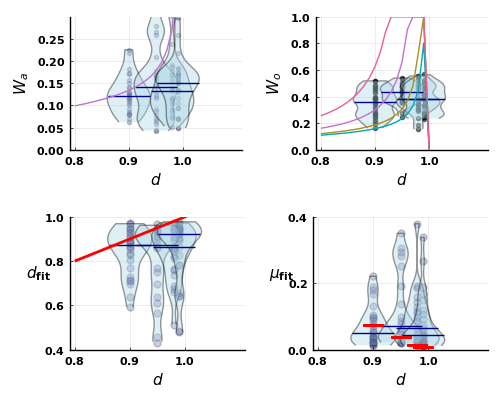

In [149]:
let tumorinfo = tumorinfo_nonspatial

    # f_min = 1
    # ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
    #     tumor_sample_col = :clonetumor_coinc,
    #     sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
        N=N, mus=tumorinfo.μ[mask], size=(500,200), scalex=10,
        usecorrection=true, xlim=[0.8,1.1])

    # ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    #     usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask];
        mus=tumorinfo.μ[mask], size=(500,200), scalex=10, xlim=[0.8,1.1], ylim_d=(0.4,1), ylim_mu=(0,0.4))

    plot(p1,p2, layout = (2,1), size=(500,400))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


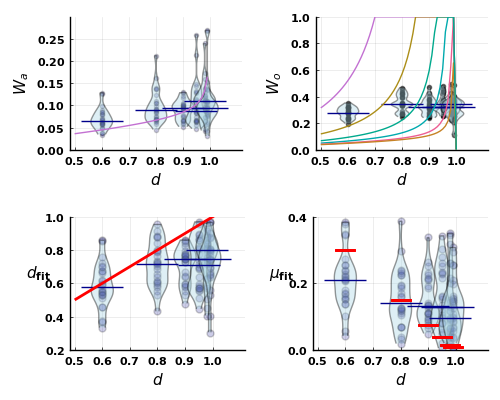

In [35]:
let tumorinfo = tumorinfo_nonspatial

    f_min = 10
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
        N=N, mus=tumorinfo.μ[mask], size=(500,200), scalex=10,
        usecorrection=true, xlim=[0.5,1.1])

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask];
        mus=tumorinfo.μ[mask], size=(500,200), scalex=10, xlim=[0.5,1.1], ylim_d=(0.2,1), ylim_mu=(0,0.4))

    plot(p1,p2, layout = (2,1), size=(500,400))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


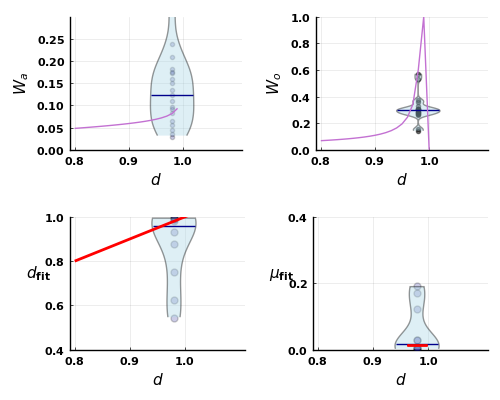

In [50]:
let tumorinfo = tumorinfo_2d

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
        N=N / f_min, mus=tumorinfo.μ[mask], size=(500,200), scalex=10,
        usecorrection=true, xlim=[0.8,1.1])

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask];
        mus=tumorinfo.μ[mask], size=(500,200), scalex=10, xlim=[0.8,1.1], ylim_d=(0.4,1), ylim_mu=(0,0.4))

    plot(p1,p2, layout = (2,1), size=(500,400))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


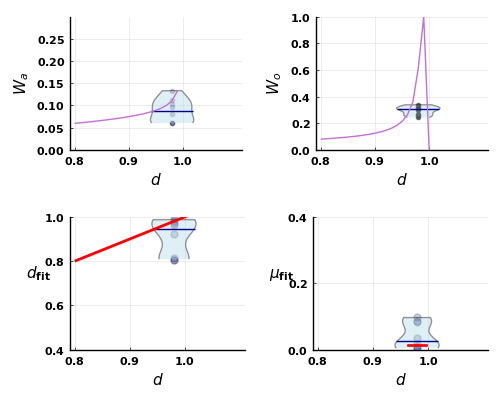

5000000
41000000
34000000


In [155]:
let tumorinfo = tumorinfo_3d

    f_min = 1
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
        N=N / f_min, mus=tumorinfo.μ[mask], size=(500,200), scalex=10,
        usecorrection=true, xlim=[0.8,1.1])

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask];
        mus=tumorinfo.μ[mask], size=(500,200), scalex=10, xlim=[0.8,1.1], ylim_d=(0.4,1), ylim_mu=(0,0.4))

    plot(p1,p2, layout = (2,1), size=(500,400))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


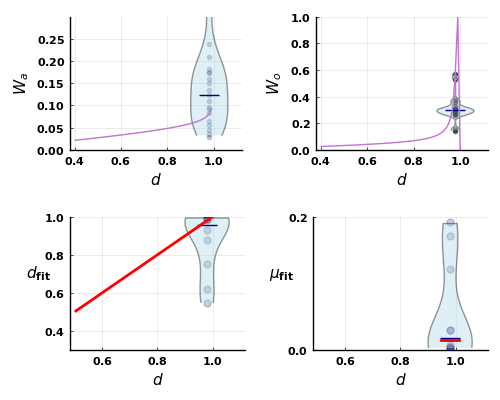

In [52]:
let tumorinfo = tumorinfo_2d

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
        N=N / f_min, mus=tumorinfo.μ[mask], size=(500,200), scalex=5,
        usecorrection=true, xlim=[0.4,1.1])

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask];
        mus=tumorinfo.μ[mask], size=(500,200), scalex=5, xlim=[0.5,1.1], ylim_d=(0.3,1), ylim_mu=(0,0.2))

    plot(p1,p2, layout = (2,1), size=(500,400))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


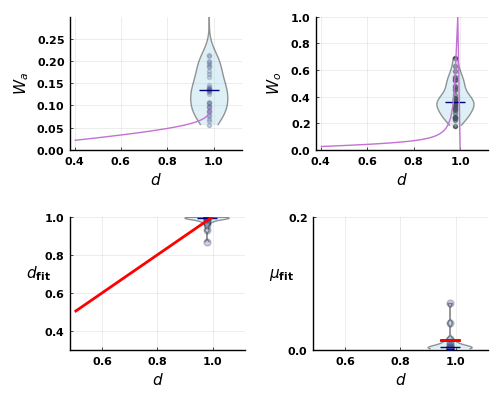

In [169]:
let tumorinfo = tumorinfo_3d

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    mask = .!(isnan.(Wo))
    p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
        N=N / f_min, mus=tumorinfo.μ[mask], size=(500,200), scalex=5,
        usecorrection=true, xlim=[0.4,1.1])

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask];
        mus=tumorinfo.μ[mask], size=(500,200), scalex=5, xlim=[0.5,1.1], ylim_d=(0.3,1), ylim_mu=(0,0.2))

    plot(p1,p2, layout = (2,1), size=(500,400))
end

## nonspatial

> samplingtumor

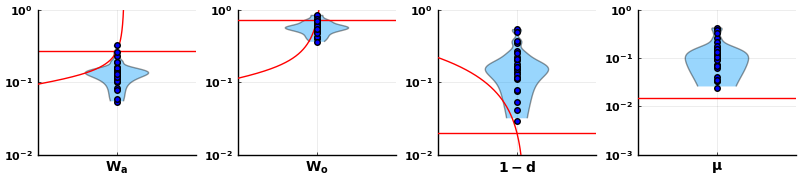

In [ ]:
println("d ", median(dfits), " | ", d , ", mu ", median(mufits),  " | ", mu , )
plot_method(ds,Wa,Wo,dfits,mufits)

> clonetumor_coinc

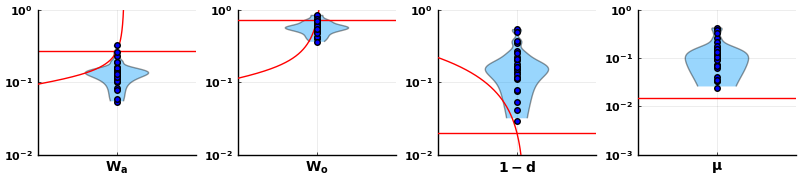

In [ ]:
println("d ", median(dfits), " | ", d , ", mu ", median(mufits),  " | ", mu , )
plot_method(ds,Wa,Wo,dfits,mufits)

> clonetumor_lichee

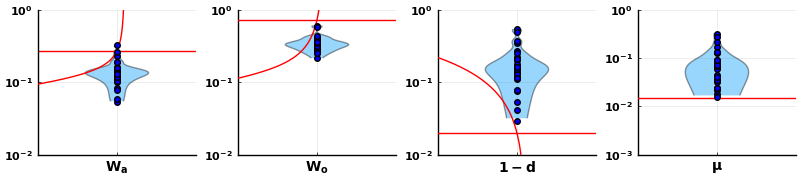

In [37]:
println("d ", median(dfits), " | ", d , ", mu ", median(mufits),  " | ", mu , )
plot_method(ds,Wa,Wo,dfits,mufits)

## 2d

In [184]:
N = 10000

10000

> samplingtumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.7127313139547854 | 0.98, mu 0.18416128545312918 | 0.015


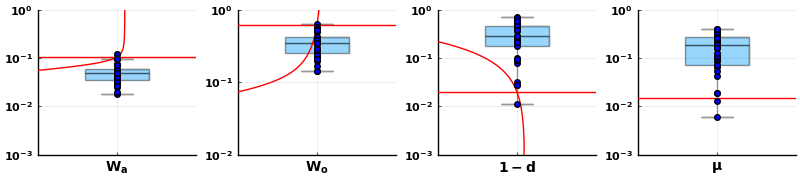

In [90]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_2d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N / f_min, d, mu, ds[mask],Wa[mask],Wo[mask],dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
    plot!(p[1], ylim=(1e-3,1))
end

> clonetumor_coinc

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9652969886282307 | 0.98, mu 0.01187615841840527 | 0.015


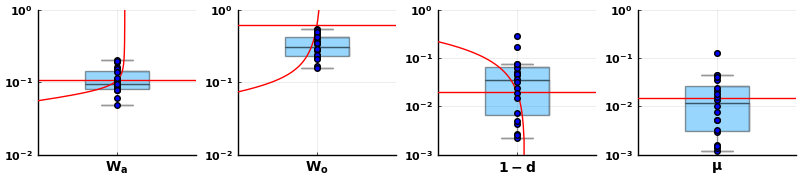

In [88]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_2d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds[mask],Wa[mask],Wo[mask],dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

> clonetumor_lichee

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9772960849667502 | 0.98, mu 0.006279833844373154 | 0.015


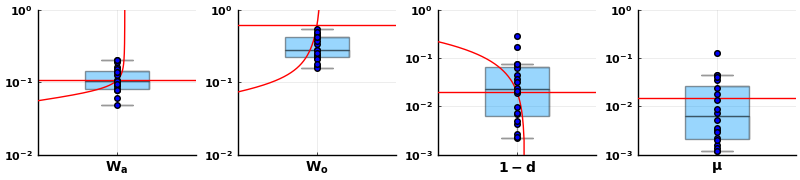

In [89]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_2d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds[mask],Wa[mask],Wo[mask],dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

## 3d

In [10]:
n = median( nrow.( tumorinfo_3d.samplingtumor ) )
N = n^(3/2) * 2/(π^(1/2)*3^(1/4))

4103.479382591604

> samplingtumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6309913196408365 | 0.98, mu 0.24926361995599428 | 0.015


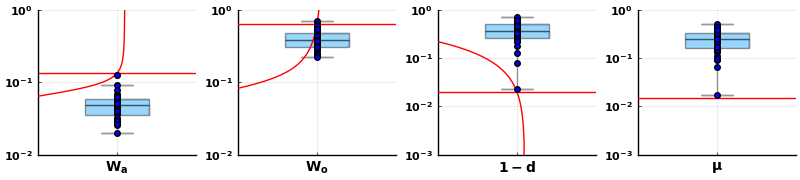

In [171]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

d 0.6309913196408365 | 0.98, mu 0.24926361995599428 | 0.015


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


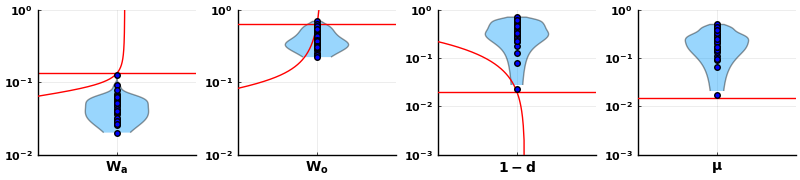

In [14]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6309913196408365 | 0.98, mu 0.24926361995599428 | 0.015


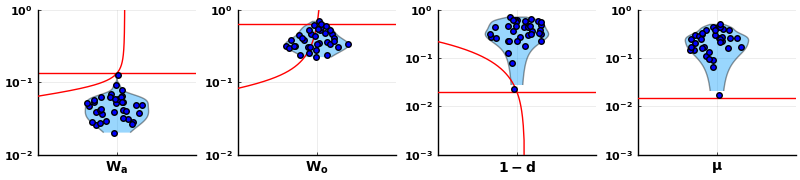

In [180]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.6309913196408365 | 0.98, mu 0.24926361995599428 | 0.015


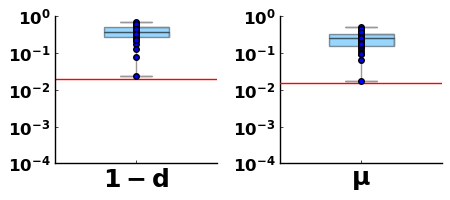

In [49]:
let
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:d, :mu],
        layout = (1,2), distribution! = boxplot!)
    plot!(p[1], ylim=(1e-4,1))
    plot!(p[2], ylim=(1e-4,1))
end

In [50]:
name = "turnover_d0.98_mu0.015_inference"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

> clonetumor_coinc

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9804464506989928 | 0.98, mu 0.009251410730153009 | 0.015


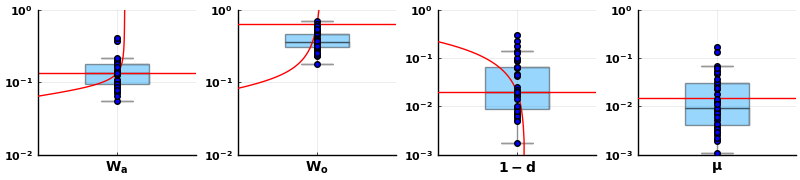

In [172]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N / f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9804464506989928 | 0.98, mu 0.009251410730153009 | 0.015


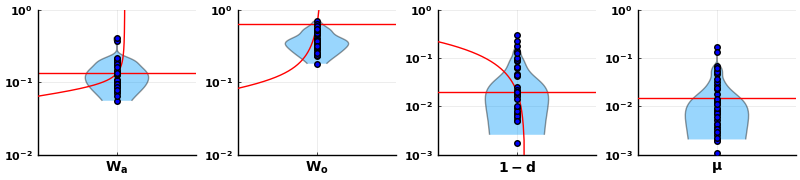

In [15]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N / f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9804464506989928 | 0.98, mu 0.009251410730153009 | 0.015


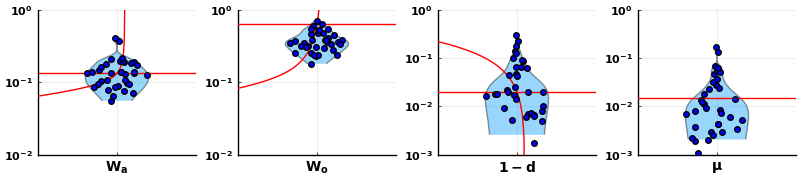

In [179]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N / f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9804464506989928 | 0.98, mu 0.009251410730153009 | 0.015


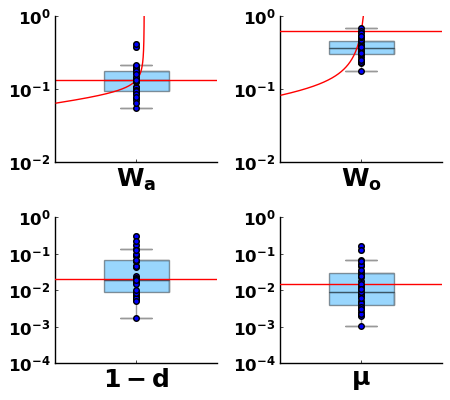

In [42]:
let
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[3], ylim=(1e-4,1))
    plot!(p[4], ylim=(1e-4,1))
end

In [43]:
name = "turnover_d0.98_mu0.015_coinc"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

> clonetumor_lichee

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9800620403899003 | 0.98, mu 0.008920628242396034 | 0.015


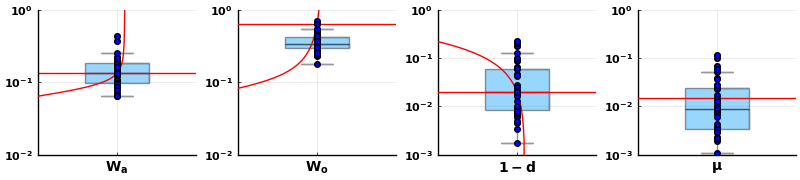

In [173]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9800620403899003 | 0.98, mu 0.008920628242396034 | 0.015


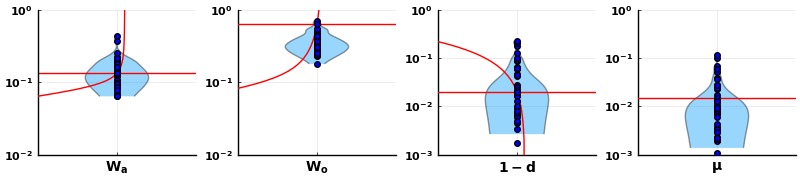

In [18]:

d, mu = 0.98, 0.015
tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
    tumor_sample_col = :clonetumor_lichee,
    sample_freq_col = :frequency,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)

println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
plot!(p[3], ylim=(1e-3,1))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9800620403899003 | 0.98, mu 0.008920628242396034 | 0.015


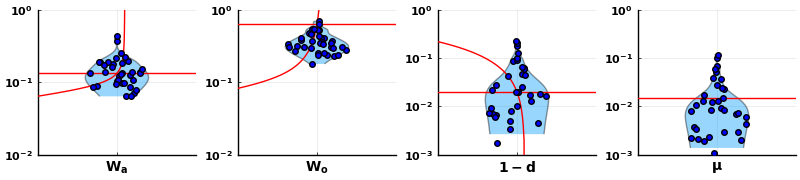

In [178]:
let 
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_method(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask])
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9800620403899003 | 0.98, mu 0.008920628242396034 | 0.015


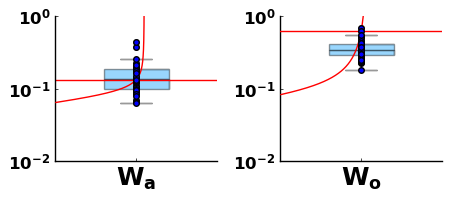

In [36]:
let
    d, mu = 0.98, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo],
        layout = (1,2), distribution! = boxplot!)
    # plot!(p[1], ylim=(1e-4,1))
    # plot!(p[2], ylim=(1e-4,1))
end

In [37]:
name = "turnover_d0.98_mu0.015_lichee_W"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

## 2d poisson

In [184]:
N = 10000

10000

> samplingtumor

> clonetumor_coinc

> clonetumor_lichee

## 3d poisson

In [25]:
n = median( nrow.( tumorinfo_3d.samplingtumor ) )
N = n^(3/2) * 2/(π^(1/2)*3^(1/4))

4103.479382591604

> samplingtumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.5713047428280295 | 0.975, mu 0.25829635842198695 | 0.015


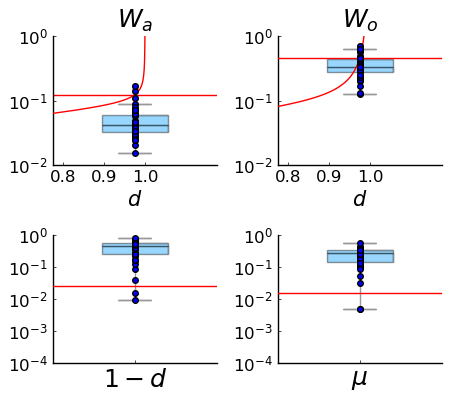

In [39]:
let
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :samplingtumor,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

In [50]:
name = "turnover_d0.98_mu0.015_inference"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

> clonetumor_coinc

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.009379275706536181 | 0.015

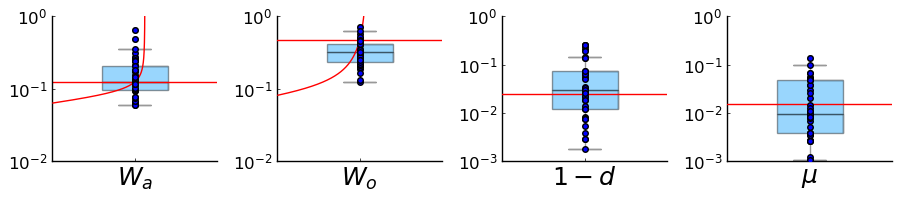

In [27]:
let 
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask]; plots = [:Wa, :Wo, :d, :mu], layout=(1,4),
        distribution! = boxplot!, dots! = scatter!, scale = 5)
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.009379275706536181 | 0.015


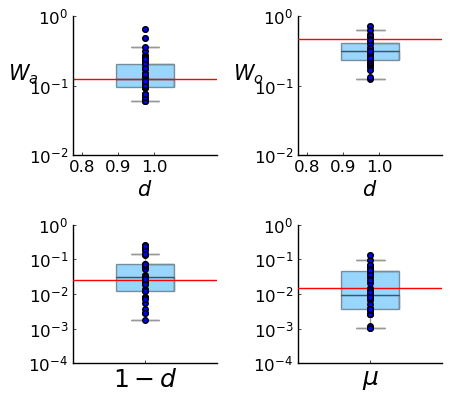

In [64]:
let
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[end-1], ylim=(1e-4,1))
    plot!(p[end], ylim=(1e-4,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.009379275706536181 | 0.015


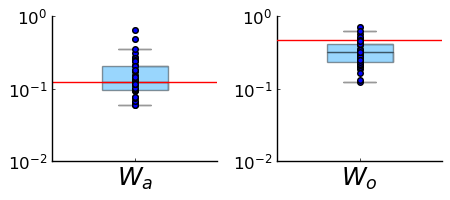

In [61]:
let
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_coinc,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo],
        layout = (1,2), distribution! = boxplot!)
    # plot!(size=(450,225))
    # plot!(p[3], ylim=(1e-4,1))
    # plot!(p[4], ylim=(1e-4,1))
end

In [65]:
name = "turnover_d0.975_mu0.015_coinc"
savefig(joinpath("Turnover\\turnover_plots\\experimental_data\\", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\experimental_data\\", name*".png"))

> clonetumor_lichee

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.008857578596414116 | 0.015


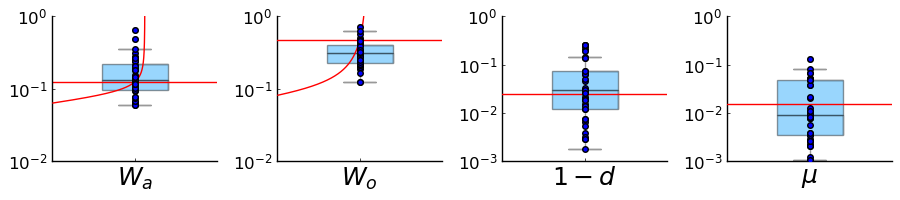

In [28]:
let 
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)
    
    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func(N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask]; plots = [:Wa, :Wo, :d, :mu], layout=(1,4),
        distribution! = boxplot!, dots! = scatter!, scale = 5)
    plot!(p[3], ylim=(1e-3,1))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


d 0.9699592809740845 | 0.975, mu 0.008857578596414116 | 0.015


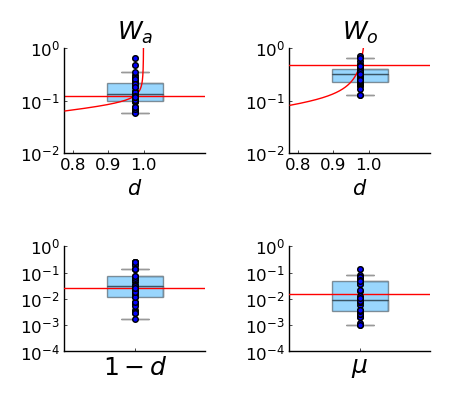

In [44]:
let
    d, mu = 0.975, 0.015
    tumorinfo = filter( r-> r.d == d && r.μ == mu, tumorinfo_3d)

    f_min = 2
    ds, Wa, Wo = get_turnover(tumorinfo; f_min=f_min,
        tumor_sample_col = :clonetumor_lichee,
        sample_freq_col = :frequency,)

    ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
        usecorrection=true, estimate_N = false, N = N/f_min)
    mask = .!ismissing.(mufits)

    println("d ", median(dfits[mask]), " | ", d , ", mu ", median(mufits[mask]),  " | ", mu , )
    p = plot_func( N/ f_min, d, mu, ds,Wa,Wo,dfits[mask],mufits[mask];
        plots = [:Wa, :Wo, :d, :mu],
        layout = (2,2), distribution! = boxplot!)
    plot!(p[3], ylim=(1e-4,1))
    plot!(p[4], ylim=(1e-4,1))
end

In [41]:
name = "turnover_d0.975_mu0.015_lichee_poisson"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))